# Modelos baseados em arvores para a modelagem do sistema
___

Essa ideia visa em facilitar o processo de treinamento, atualização e modelagem do sistema hidraulico do LENHS que será utilizado em conjunto com um sistema de controle Fuzzy.

In [269]:
!$PWD

'$PWD' não é reconhecido como um comando interno
ou externo, um programa operável ou um arquivo em lotes.


## Bibliotecas

In [270]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
try:
    #sys.path.append('/home/enacom/Documentos/github/smart-automation/utils/')
    sys.path.append(r'C:\Users\ra-no\OneDrive\Documentos\GitHub\smart-automation\utils')
    from get_metrics import get_metrics
    from create_figures import create_figures
    for path in sys.path:
        print(path)
except ImportError:
    print('Import error')

Import error


## Dados de teste e treino

In [271]:
data = pd.read_parquet('./data/1s/train_test_data.parquet')
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6241 entries, 0 to 6240
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Frequencia CMB  6241 non-null   float64
 1   CV-1            6241 non-null   float64
 2   PT-1            6241 non-null   float64
 3   PT-2            6241 non-null   float64
 4   PT-3            6241 non-null   float64
dtypes: float64(5)
memory usage: 243.9 KB


In [272]:
for column in data.columns:
    data[column] = data[column].rolling(5).mean()

data.dropna(inplace=True)

In [273]:
data.columns

Index(['Frequencia CMB', 'CV-1', 'PT-1', 'PT-2', 'PT-3'], dtype='object')

In [274]:
x_train, x_test, y_train, y_test = train_test_split(
    data[['Frequencia CMB', 'CV-1']],
    data[['PT-1', 'PT-2', 'PT-3']],
    test_size=0.3,
    random_state=812,
    shuffle=False
)

print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (4365, 2)
x_test shape: (1872, 2)
y_train shape: (4365, 3)
y_test shape: (1872, 3)


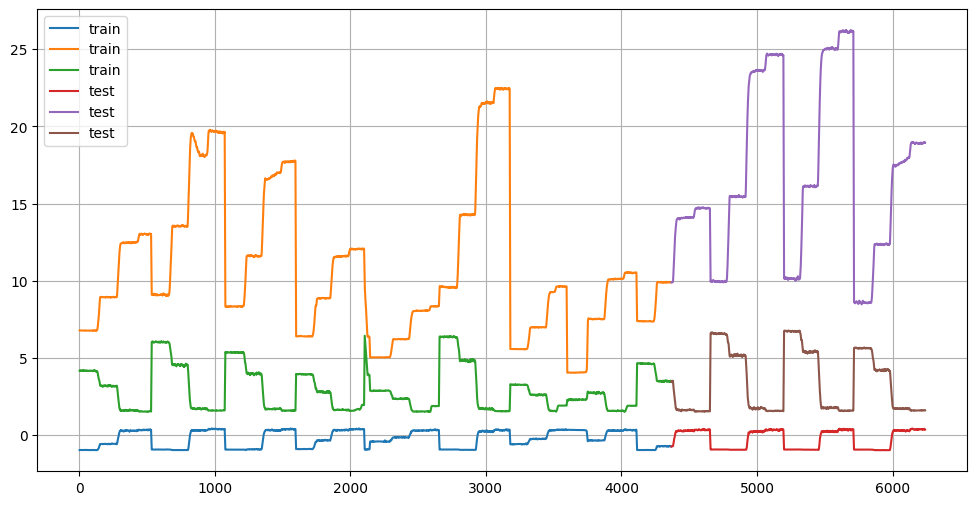

In [275]:
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='train')
plt.plot(y_test, label='test')
plt.grid()
plt.legend()

## Decision Tree Model

In [276]:
dt_model = DecisionTreeRegressor(
    max_depth=3,
    # random_state=812,
)
dt_model

DecisionTreeRegressor(max_depth=3)

In [277]:
dt_model.fit(
    x_train,
    y_train
)

DecisionTreeRegressor(max_depth=3)

In [278]:
dt_model.score(x_train, y_train)

0.9212360882122

In [279]:
predicted = dt_model.predict(x_test)
predicted

array([[-0.76461264,  7.96911062,  3.75384316],
       [-0.76461264,  7.96911062,  3.75384316],
       [-0.76461264,  7.96911062,  3.75384316],
       ...,
       [ 0.30873429, 18.08003277,  1.69545175],
       [ 0.30873429, 18.08003277,  1.69545175],
       [ 0.30873429, 18.08003277,  1.69545175]])

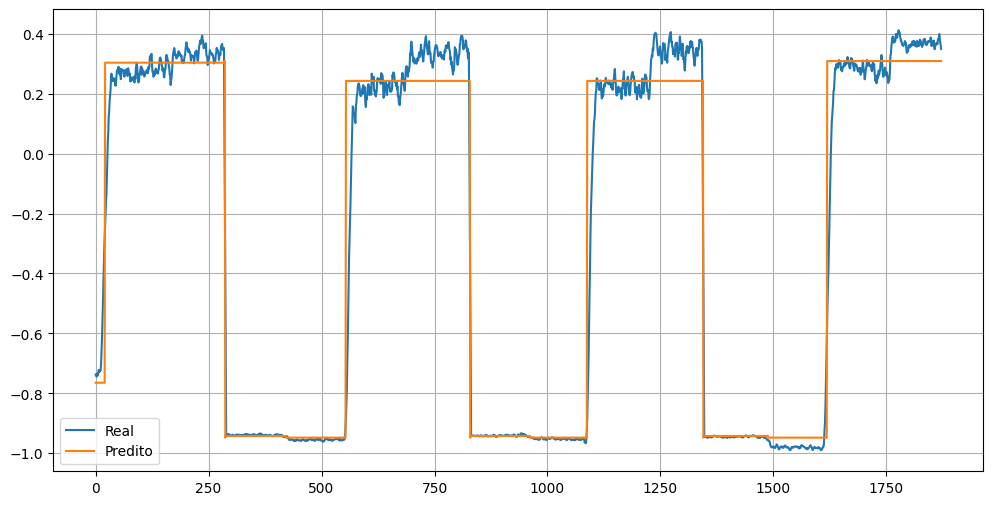

In [280]:
plt.figure(figsize=(12, 6))
plt.plot(y_test['PT-1'].values, label='Real')
plt.plot(predicted[:, 0], label='Predito')
plt.legend()
plt.grid()
plt.show()

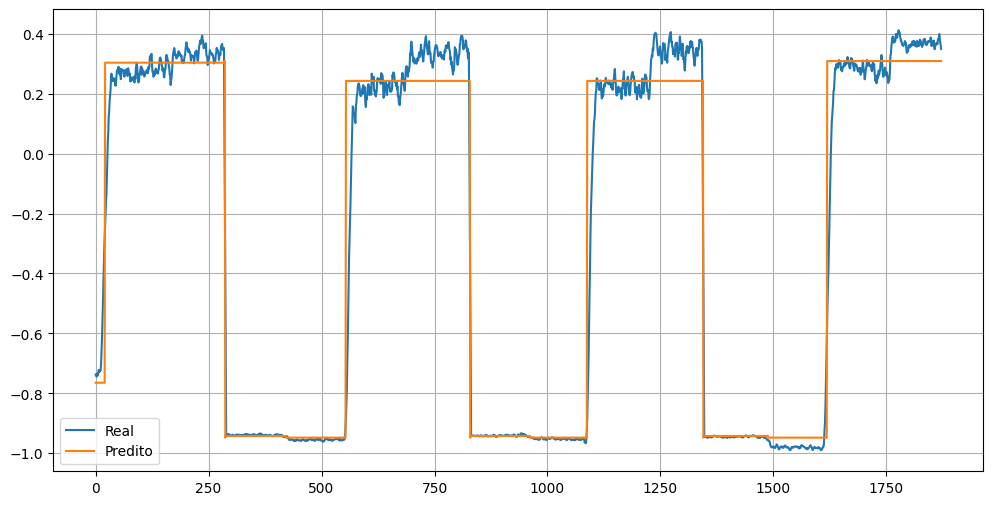

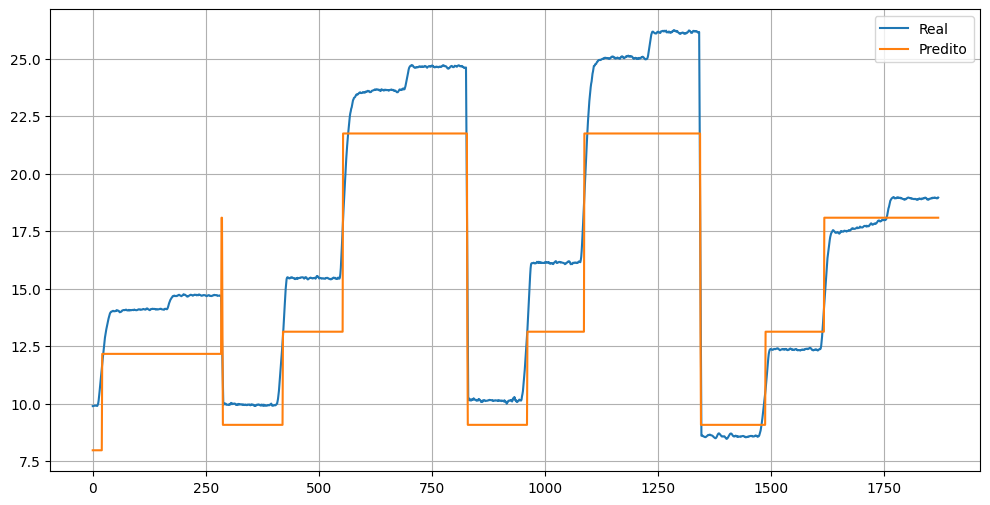

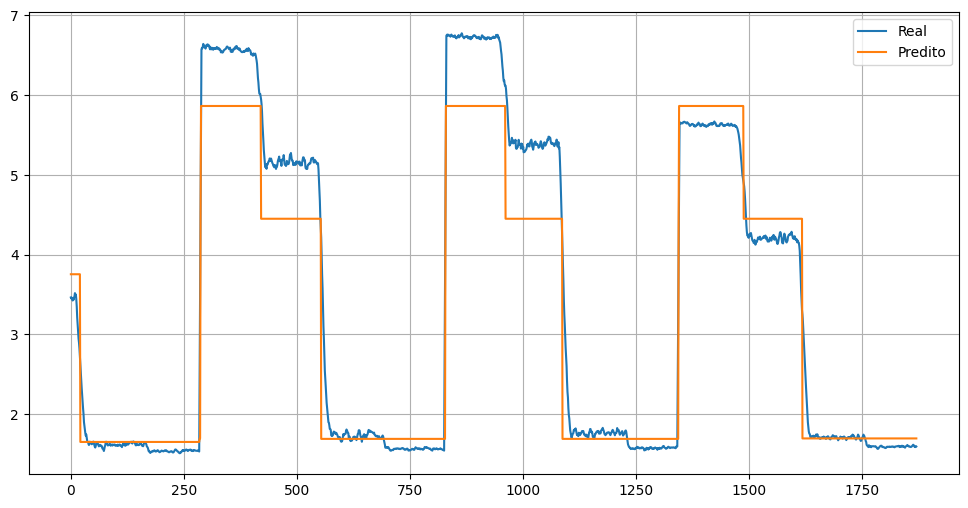

In [281]:
for col in enumerate(y_test.columns):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[col[1]].values, label='Real')
    plt.plot(predicted[:, col[0]], label='Predito')
    plt.legend()
    plt.grid()
    plt.show()

In [282]:
dt_model.feature_importances_

array([0.52542072, 0.47457928])

[Text(0.5, 0.875, 'Frequencia CMB <= 45.6\nsquared_error = 8.064\nsamples = 4365\nvalue = [[-0.248]\n[10.742]\n[2.938]]'),
 Text(0.25, 0.625, 'CV-1 <= 38.763\nsquared_error = 2.343\nsamples = 2780\nvalue = [[-0.188]\n[8.329]\n[2.612]]'),
 Text(0.125, 0.375, 'Frequencia CMB <= 36.9\nsquared_error = 1.091\nsamples = 1702\nvalue = [[-0.497]\n[6.902]\n[3.208]]'),
 Text(0.0625, 0.125, 'squared_error = 0.52\nsamples = 860\nvalue = [[-0.236]\n[5.856]\n[2.674]]'),
 Text(0.1875, 0.125, 'squared_error = 0.68\nsamples = 842\nvalue = [[-0.765]\n[7.969]\n[3.754]]'),
 Text(0.375, 0.375, 'Frequencia CMB <= 37.3\nsquared_error = 0.943\nsamples = 1078\nvalue = [[0.3]\n[10.582]\n[1.67]]'),
 Text(0.3125, 0.125, 'squared_error = 0.322\nsamples = 585\nvalue = [[0.297]\n[9.252]\n[1.686]]'),
 Text(0.4375, 0.125, 'squared_error = 0.149\nsamples = 493\nvalue = [[0.303]\n[12.16]\n[1.651]]'),
 Text(0.75, 0.625, 'CV-1 <= 36.111\nsquared_error = 8.545\nsamples = 1585\nvalue = [[-0.352]\n[14.974]\n[3.511]]'),
 Text

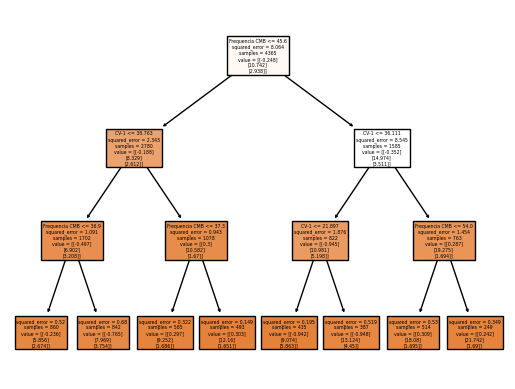

In [283]:
plot_tree(
    dt_model,
    filled=True,
    feature_names=x_train.columns,
    class_names=['PT-1', 'PT-2', 'PT-3'],
)

## CatBoost Model

In [284]:
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.01,
    depth=3,
    verbose=0,
)
cat_model

In [285]:
cat_model.fit(
    x_train,
    y_train['PT-1'],
)

In [286]:
cat_model.score(x_train, y_train['PT-1'])

0.9849937659115718

In [287]:
cat_predicted = cat_model.predict(x_test)
cat_predicted

array([-0.74479171, -0.74693167, -0.74477596, ...,  0.3669794 ,
        0.36779969,  0.36779969])

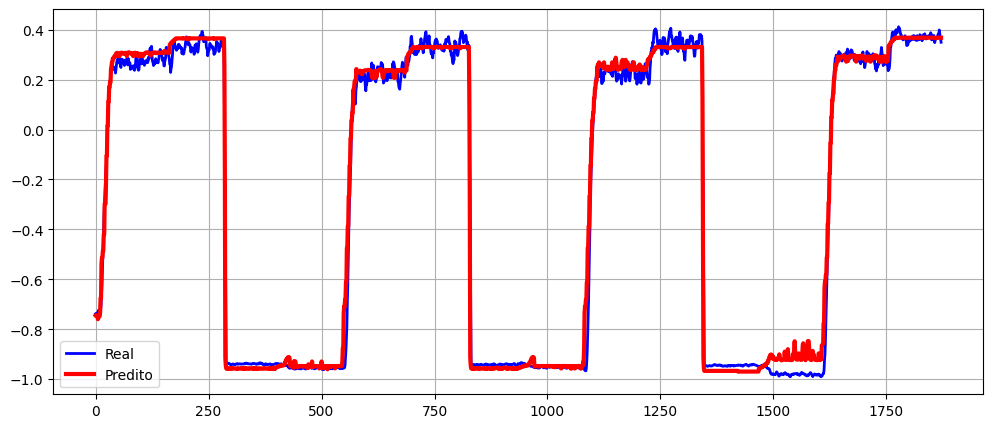

In [288]:
plt.figure(figsize=(12, 5))
plt.plot(y_test['PT-1'].values, label='Real', linewidth=2, color='blue')
plt.plot(cat_predicted, label='Predito', linewidth=3, color='red')
plt.legend()
plt.grid()
plt.show()

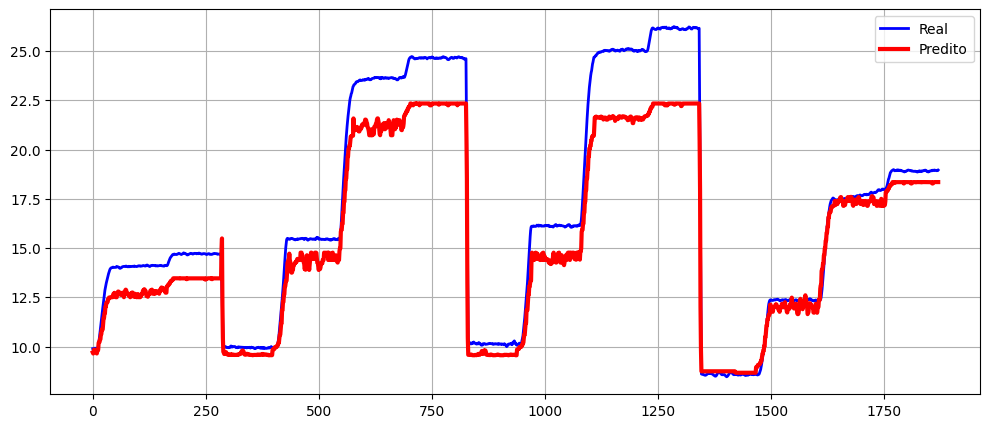

In [289]:
cat_model2 = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.01,
    depth=3,
    verbose=0,
)

cat_model2.fit(
    x_train,
    y_train['PT-2'],
)

cat_model2.score(x_train, y_train['PT-2'])

plt.figure(figsize=(12, 5))
plt.plot(y_test['PT-2'].values, label='Real', linewidth=2, color='blue')
plt.plot(cat_model2.predict(x_test), label='Predito', linewidth=3, color='red')
plt.legend()
plt.grid()
plt.show()

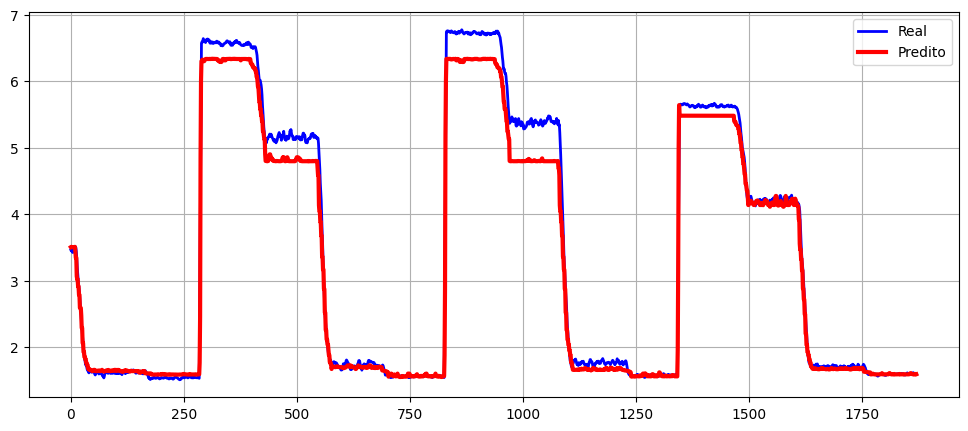

In [290]:
cat_model3 = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.01,
    depth=3,
    verbose=0,
)

cat_model3.fit(
    x_train,
    y_train['PT-3'],
)

cat_model3.score(x_train, y_train['PT-3'])

plt.figure(figsize=(12, 5))
plt.plot(y_test['PT-3'].values, label='Real', linewidth=2, color='blue')
plt.plot(cat_model3.predict(x_test), label='Predito', linewidth=3, color='red')
plt.legend()
plt.grid()
plt.show()